In [79]:
import pyroomacoustics as pra
import soundfile as sf
import numpy as np
import pydub
import tensorflow as tf
import random
import IPython.display as ipd
import glob
import os
import subprocess
import matplotlib.pyplot as plt
import librosa

In [21]:
sr=16000

In [4]:
tfrecord_file = '../data/_clean_speech_00_0000.tfrecord'

In [5]:
examples = []
limit = 100
for i, example in enumerate(tf.python_io.tf_record_iterator(tfrecord_file)):
    eg_np = tf.train.Example.FromString(example)
    audio_segment = pydub.AudioSegment(
        eg_np.features.feature["audio"].bytes_list.value[0], 
        frame_rate=16000,
        sample_width=2, 
        channels=1
    )
    y = audio_segment.get_array_of_samples()
    examples.append(y)
    if i > limit:
        break

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [45]:
def normalize_power(clip):
    avg_power = np.sqrt((clip**2).sum() / clip.size)
    return clip / avg_power

In [53]:
def noisy_augment_audio_1source(wakeword, room_dims, corners, height, source_pos,
                        mic_pos, mic_n, mic_radius, room_absorption, plot=False):
    
    room = pra.Room.from_corners(corners, fs=16000, absorption=room_absorption)
    room.extrude(height)
    
    wakeword_norm = normalize_power(wakeword)
    room.add_source(source_pos, signal=wakeword_norm)

    R = pra.circular_2D_array(mic_pos[:2], mic_n, 0, mic_radius)
    R = np.concatenate((R, np.ones((1, mic_n)) * mic_pos[2]), axis=0)
    mics = pra.MicrophoneArray(R, 16000)
    room.add_microphone_array(mics)
    
    if plot:
        fig, ax = room.plot()
        ax.set_xlim([0, room_dims[0] + 1])
        ax.set_ylim([0, room_dims[1] + 1])
        ax.set_zlim([0, room_dims[2] + 1])
        plt.show()
    
    room.simulate()
    mono = np.sum(room.mic_array.signals, axis=0)
    mono = mono / mic_n
    
    return mono

In [54]:
def noisy_augment_audio_2source(wakeword, noise1, room_dims, corners, height, pos1, pos2, 
                                mic_pos, mic_n, mic_radius, room_absorption, plot=False):
    
    room = pra.Room.from_corners(corners, fs=16000, absorption=room_absorption)
    room.extrude(height)

    wakeword_norm = normalize_power(wakeword)
    room.add_source(pos1, signal=wakeword_norm)

    noise1_norm = normalize_power(noise1)
    room.add_source(pos2,signal=noise1_norm)

    R = pra.circular_2D_array(mic_pos[:2], mic_n, 0, mic_radius)
    R = np.concatenate((R, np.ones((1, mic_n)) * mic_pos[2]), axis=0)
    mics = pra.MicrophoneArray(R, 16000)
    room.add_microphone_array(mics)
    
    if plot:
        fig, ax = room.plot()
        ax.set_xlim([0, room_dims[0] + 1])
        ax.set_ylim([0, room_dims[1] + 1])
        ax.set_zlim([0, room_dims[2] + 1])
        plt.show()
    
    room.simulate()
    mono = np.sum(room.mic_array.signals, axis=0)
    mono = mono / mic_n
    
    return mono

In [55]:
def noisy_augment_audio_3source(wakeword, noise1, noise2, room_dims, corners, height, 
                                pos1, pos2, pos3, mic_pos, mic_n, mic_radius, room_absorption, plot=False):
    
    room = pra.Room.from_corners(corners, fs=16000, absorption=room_absorption)
    room.extrude(height)
    
    wakeword_norm = normalize_power(wakeword)
    room.add_source(pos1, signal=wakeword_norm)
    
    noise1_norm = normalize_power(noise1)
    room.add_source(pos2, signal=noise1_norm)
    
    noise2_norm = normalize_power(noise2)
    room.add_source(pos3, signal=noise2_norm)

    R = pra.circular_2D_array(mic_pos[:2], mic_n, 0, mic_radius)
    R = np.concatenate((R, np.ones((1, mic_n)) * mic_pos[2]), axis=0)
    mics = pra.MicrophoneArray(R, 16000)
    room.add_microphone_array(mics)
    
    if plot:
        fig, ax = room.plot()
        ax.set_xlim([0, room_dims[0] + 1])
        ax.set_ylim([0, room_dims[1] + 1])
        ax.set_zlim([0, room_dims[2] + 1])
        plt.show()
    
    room.simulate()
    mono = np.sum(room.mic_array.signals, axis=0)
    mono = mono / mic_n
    
    return mono[:32000]

In [56]:
def get_RIR_opts(num_sources):
    
    room1_dim = [40, 8, 8]
    room1_corners = np.array([[0,0], [0,8], [40,8], [40,0]]).T
    room1_height = 8
    room1_pos1 = [3, 4, 4]
    room1_pos2 = [38, 1, 2]
    room1_pos3 = [38, 7, 2]
    room1_mic_pos = [20, 4, 4]
    room1_n_mic = 4
    room1_mic_radius = .4
    room1_absorption = 0.2
    
    room2_dim = [40, 40, 10]
    room2_corners = np.array([[0,0], [0,40], [15,40], [15,15], [40,15],[40,0]]).T
    room2_height = 10
    room2_pos1 = [3, 38, 6]
    room2_pos2 = [38, 3, 6]
    room2_pos3 = [10, 10, 5]
    room2_mic_pos = [1, 1, 4]
    room2_n_mic = 4
    room2_mic_radius = .4
    room2_absorption = 0
    
    room3_dim = [30, 25, 15]
    room3_corners = np.array([[0,5], [0,25], [30,25], [30,0], [25,0],[25,5]]).T
    room3_height = 15
    room3_pos1 = [6, 6, 6]
    room3_pos2 = [5, 23, 5]
    room3_pos3 = [25, 20, 6]
    room3_mic_pos = [28, 1, 4]
    room3_n_mic = 4
    room3_mic_radius = .4
    room3_absorption = 0
    
    room = random.randint(0,2)
    if room == 0:
        rand_pos = random.sample([room1_pos1, room1_pos2, room1_pos3], num_sources)
        dim = room1_dim
        corners = room1_corners
        height = room1_height
        source_pos = rand_pos
        mic_pos = room1_mic_pos
        n_mic = room1_n_mic
        mic_radius = room1_mic_radius
        absorption = room1_absorption
    elif room == 1:
        rand_pos = random.sample([room2_pos1, room2_pos2, room2_pos3], num_sources)
        dim = room2_dim
        corners = room2_corners
        height = room2_height
        source_pos = rand_pos
        mic_pos = room2_mic_pos
        n_mic = room2_n_mic
        mic_radius = room2_mic_radius
        absorption = room2_absorption
    else:
        rand_pos = random.sample([room3_pos1, room3_pos2, room3_pos3], num_sources)
        dim = room3_dim
        corners = room3_corners
        height = room3_height
        source_pos = rand_pos
        mic_pos = room3_mic_pos
        n_mic = room3_n_mic
        mic_radius = room3_mic_radius
        absorption = room3_absorption
        
    return dim, corners, height, source_pos, mic_pos, n_mic, mic_radius, absorption

In [10]:
n_files = glob.glob('../data/LibriSpeech/train-clean-100/*/*/*.flac')
p_files = glob.glob('../data/alexa/alexa/*/*.wav')
mus_files = glob.glob('../data/fma_small/*/*.wav')

In [159]:
mus_ex = mus_files[random.randint(0,len(mus_files) - 1)]

In [160]:
ipd.Audio(mus_ex, rate=sr)

In [16]:
#for m in mus_files:
#    pre, ext = os.path.splitext(m)
#    new = pre + ".wav"
#    subprocess.call(["ffmpeg", "-i", m, "-vn", "-acodec", "pcm_s16le", "-ac", "1", "-ar", "16000", "-f", "wav", new])

In [17]:
#for m in mus_files:
#    os.remove(m)

In [59]:
p_ex, _ = sf.read(p_files[random.randint(0,len(p_files) - 1)])
n_ex, _ = sf.read(mus_files[random.randint(0,len(mus_files) - 1)])

In [35]:
ipd.Audio(p_ex, rate=sr)

In [36]:
ipd.Audio(n_ex, rate=sr)

In [60]:
room1_dim = [40, 8, 8]
room1_corners = np.array([[0,0], [0,8], [40,8], [40,0]]).T
room1_height = 8
room1_pos1 = [3, 4, 4]
room1_pos2 = [38, 1, 2]
room1_pos3 = [38, 7, 2]
room1_mic_pos = [20, 4, 4]
room1_n_mic = 4
room1_mic_radius = .4
room1_absorption = 0.2

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


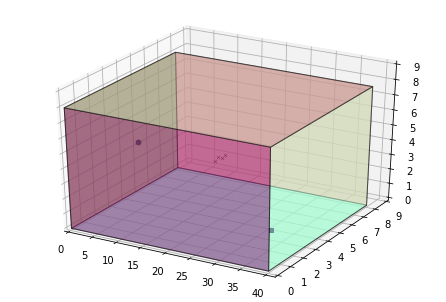

In [61]:
room1_mix = noisy_augment_audio_2source(p_ex, n_ex, room1_dim, room1_corners, room1_height, room1_pos1, room1_pos2, 
                                     room1_mic_pos, room1_n_mic, room1_mic_radius, room1_absorption, plot=True)

In [62]:
print("Original wakeword")
ipd.Audio(p_ex, rate=sr)

Original wakeword


In [63]:
print("Augmented with Room1 background noise & RIR:")
ipd.Audio(room1_mix, rate=sr)

Augmented with Room1 background noise & RIR:


In [64]:
room2_dim = [40, 40, 10]
room2_corners = np.array([[0,0], [0,40], [15,40], [15,15], [40,15],[40,0]]).T
room2_height = 10
room2_pos1 = [3, 38, 6]
room2_pos2 = [38, 3, 6]
room2_pos3 = [10, 10, 5]
room2_mic_pos = [1, 1, 4]
room2_n_mic = 4
room2_mic_radius = .4
room2_absorption = 0

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


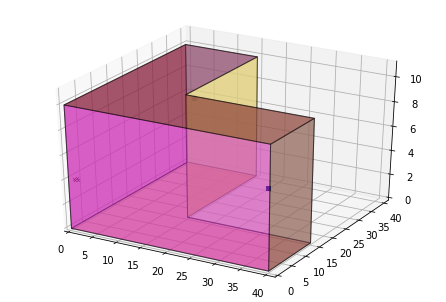

In [65]:
room2_mix = noisy_augment_audio_2source(p_ex, n_ex, room2_dim, room2_corners, room2_height, room2_pos1, room2_pos2, 
                                     room2_mic_pos, room2_n_mic, room2_mic_radius, room2_absorption, plot=True)

In [66]:
print("Original wakeword")
ipd.Audio(p_ex, rate=sr)

Original wakeword


In [67]:
print("Augmented with background noise and RIR:")
ipd.Audio(room2_mix, rate=sr)

Augmented with background noise and RIR:


In [68]:
room3_dim = [30, 25, 15]
room3_corners = np.array([[0,5], [0,25], [30,25], [30,0], [25,0],[25,5]]).T
room3_height = 15
room3_pos1 = [6, 6, 6]
room3_pos2 = [5, 23, 5]
room3_pos3 = [25, 20, 6]
room3_mic_pos = [28, 1, 4]
room3_n_mic = 4
room3_mic_radius = .4
room3_absorption = 0

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


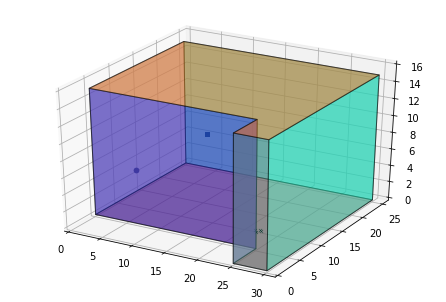

In [69]:
room3_mix = noisy_augment_audio_2source(p_ex, n_ex, room3_dim, room3_corners, room3_height, room3_pos1, room3_pos2, 
                                        room3_mic_pos, room3_n_mic, room3_mic_radius, room3_absorption, plot=True)

In [70]:
print("Original wakeword")
ipd.Audio(p_ex, rate=sr)

Original wakeword


In [71]:
print("Augmented with background noise and RIR:")
ipd.Audio(room2_mix, rate=sr)

Augmented with background noise and RIR:


In [76]:
p_ex, _ = sf.read(p_files[random.randint(0,len(p_files) - 1)])
n_ex, _ = sf.read(mus_files[random.randint(0,len(mus_files) - 1)])
n_ex2, _ = sf.read(mus_files[random.randint(0,len(mus_files) - 1)])

source_num = random.randint(1,3)
room_dims, corners, height, source_pos, mic_pos, n_mic, mic_radius, absorption = get_RIR_opts(source_num)

if source_num == 1:
    pos1 = source_pos[0]
    room_mix = noisy_augment_audio_1source(p_ex, room_dims, corners, height, pos1,
                                           mic_pos, n_mic, mic_radius, absorption)
elif source_num == 2:
    pos1 = source_pos[0]
    pos2 = source_pos[1]
    room_mix = noisy_augment_audio_2source(p_ex, n_ex, room_dims, corners, height, pos1, pos2, 
                                           mic_pos, n_mic, mic_radius, absorption)
else:
    pos1 = source_pos[0]
    pos2 = source_pos[1]
    pos3 = source_pos[2]
    room_mix = noisy_augment_audio_3source(p_ex, n_ex, n_ex2, room_dims, corners, height, 
                                           pos1, pos2, pos3, mic_pos, n_mic, mic_radius, absorption)


In [77]:
print("Original wakeword")
ipd.Audio(p_ex, rate=sr)

Original wakeword


In [78]:
print("Augmented with RIR and " + str(source_num - 1) + " background sources:")
ipd.Audio(room_mix, rate=sr)

Augmented with RIR and 0 background sources:
